# Dominant colors

To drive the Hue lights we need to determine the color they should be set to.
The simplest approach is to calculate the mean of the RGB components.  However,
this tends to result in a washed out look.  Colors average to brown or gray.

Other algorithms using clustering.  K-means is the most promising of these algorithms.
Unfortunately k-means is computationally expensive and performance suffers when performed
on every video frame.

This notebook experiments with different implementations.

## Conclusion

While the mean color is not ideal, it is by far the most performant.
Further experiments with boosting color saturation gave reasonable results.

## Obtain a test image

In [51]:
from PIL import Image
import numpy as np

image = Image.open("examples/colors.jpg")

print(image.mode)

image_data = np.asarray(image, dtype=np.uint8)

print(image_data.shape)

RGB
(1200, 1920, 3)


# Comparison of Algorithims

## Descriptions

### Mean

The mean is the average RGB value.  This tends to result in a washed out look.

### K-means -- dominantcolors

K-means clustering using the "dominantcolor" library.  This is an algorithm that attempts to find clusters within the data.
Results are good but computationally expensive.

### K-means -- scikit learn

K-means clustering using scikit learn.  Results are good but not as performant as the dominantcolors implementation.
Library uses all CPU cores impacting performance for the main application.

scikit learn allows initial clusters to be provided.  This is promising when dealing with a video stream because
clusters should not change significantly frame-to-frame.

### K-means -- scikit learn with ransom subsample

Clusters are not necessarily stable iteration to iteration.  This could lead to flickering.

### Histogram

The problem with histograms on per-channel basis is that primary colors have channels with a lot of zeros.
This results in black oftern being the peak for each channel.

### Median cut quanitzation

Promising but not as performant has I had hoped.

In [52]:
import dominantcolors
import time
import pandas as pd
import cv2
from IPython.display import HTML
from sklearn.cluster import KMeans
from sklearn.utils import shuffle


def algo_mean(data) -> tuple[int, int, int]:
    r = int(np.mean(data[:,:,0]))
    g = int(np.mean(data[:,:,1])) 
    b = int(np.mean(data[:,:,2]))
    
    return (r, g, b)

def algo_dominantcolor_lib(data, num_color) -> tuple[int, int, int]:
    dominant_colors = dominantcolors.find_dominant_colors(data, num_color)
    (r,g,b) = dominant_colors[0]
    return (r, g, b)

def algo_sklearn(data, num_color):
    kmeans = KMeans(n_clusters=num_color, init='k-means++').fit(data.reshape(-1,3))
    centroids = kmeans.cluster_centers_.astype("uint8")
    return tuple(centroids[0])
    
def algo_sklearn_sub(data, num_color):
    image_array_sample = shuffle(data.reshape(-1,3), random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=num_color, random_state=0).fit(image_array_sample)
    centroids = kmeans.cluster_centers_.astype("uint8")
    return tuple(centroids[0])

def algo_histogram(data, num_color):
    hist_range = 2 ** (num_color + 1)
    hist_r = np.histogram(data[:,:,0], bins=hist_range)
    hist_g = np.histogram(data[:,:,1], bins=hist_range)
    hist_b = np.histogram(data[:,:,2], bins=hist_range)

    peak_r = hist_r[0].argmax()
    peak_g = hist_g[0].argmax()
    peak_b = hist_b[0].argmax()

    return (peak_r, peak_g, peak_b) 

def algo_median_cut(data, num_color: int):
    num_colors = 2 ** (num_color + 1)
    # Initial setup: Reshape the image array to a flat list of pixels
    pixels = data.reshape(-1, 3)
    
    # Convert the pixels to a list of tuples initially containing one box
    boxes = [pixels]

    # Perform iterative splitting until the number of boxes equals num_colors
    while len(boxes) < num_colors:
        # Create a new list to store the resulting boxes
        new_boxes = []
        for box in boxes:
            # Calculate the range for each channel
            ranges = [np.ptp(box[:, i]) for i in range(3)]
            # Determine the channel with the max range
            channel = np.argmax(ranges)

            # Sort the box by the selected channel
            box = box[box[:, channel].argsort()]

            # Determine the median index
            median = len(box) // 2

            # Split at the median and form two new boxes
            new_boxes.append(box[:median])    # First half
            new_boxes.append(box[median:])    # Second half

        # Update the boxes list with the newly created boxes
        boxes = new_boxes

    # Find the box with the largest number of pixels
    largest_box = max(boxes, key=lambda box: box.shape[0])

    # For reference: average color of the largest box
    largest_box_color = np.mean(largest_box, axis=0)

    # Reshape to the original image shape
    return largest_box_color.astype(np.uint8)


results = []
images = [
    image_data,
    cv2.resize(image_data, (640, 320), interpolation = cv2.INTER_AREA),
    cv2.resize(image_data, (320, 160), interpolation = cv2.INTER_AREA),
    cv2.resize(image_data, (160, 80), interpolation = cv2.INTER_AREA)
]
alogorithms = ["mean", "dc_lib", "sklearn", "sklearn_sub", "histo", "median_cut"]
num_colors = [2,3, 4]
num_iterations = 5

for algo in alogorithms:
    for im in images:
        for num_color in num_colors:
            times = []
            result = None
            for _ in range(num_iterations):
                start = time.time()
                
                if algo == "mean":
                    result = algo_mean(im)
                elif algo == "dc_lib":
                    result = algo_dominantcolor_lib(im, num_color)
                elif algo == "sklearn":
                    result = algo_sklearn(im, num_color)
                elif algo == "sklearn_sub":
                    result = algo_sklearn_sub(im, num_color)
                elif algo == "histo":
                    result = algo_histogram(im, num_color)
                elif algo == "median_cut":
                    result = algo_median_cut(im, num_color)
                else:
                    raise Exception("Invalid algorithm")
                    
                times.append(time.time()-start)
                
            # Only take the last result,  Assume that is is representative.
            results.append((result, algo, im.shape, num_color, np.mean(times), np.std(times)))
    
results_df = pd.DataFrame(results, columns=["Color", "Algorithm", "Size", "#Color", "Mean Time", "Standard Deviation"])

def rgb_to_color_swatch(rgb):
    r, g, b = rgb
    return f'<div style="background-color:rgb({r},{g},{b}); width:50px; height:20px; border:1px solid black;"></div>'

# Convert the Color column to HTML color swatches
results_df['Color'] = results_df['Color'].apply(rgb_to_color_swatch)

# HTML(results_df.to_html(escape=False))

    


# Visualize the results

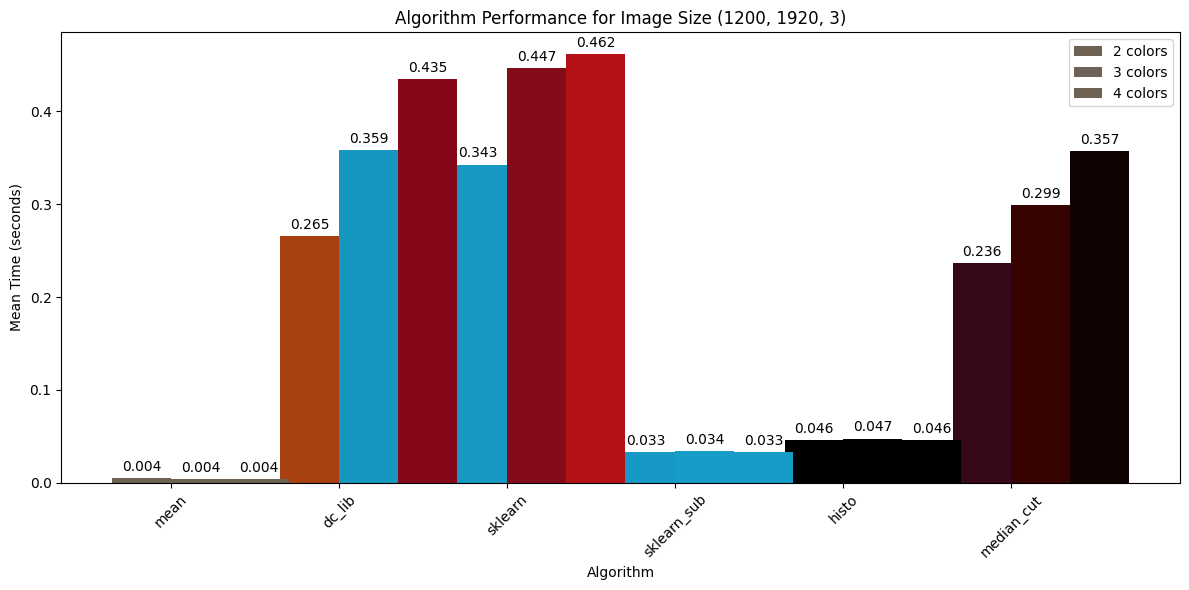

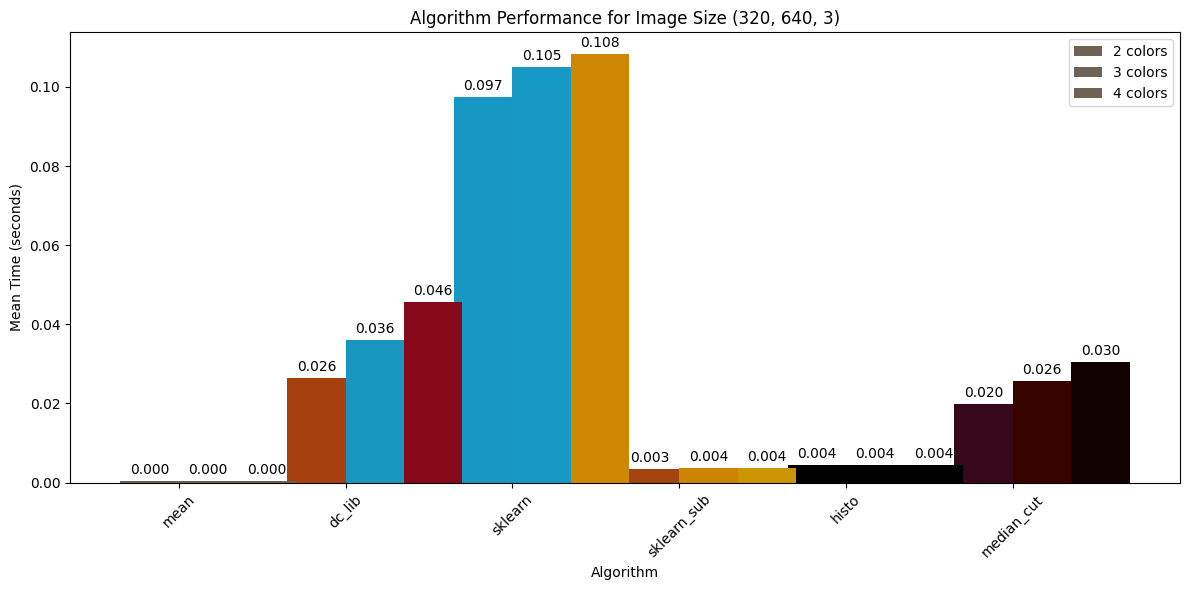

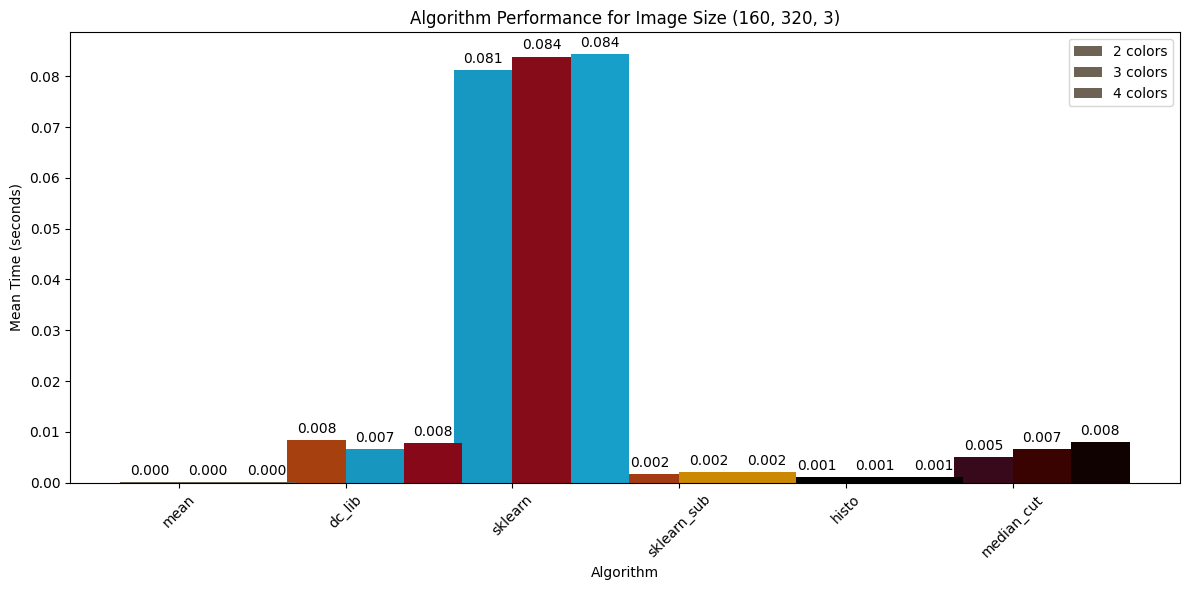

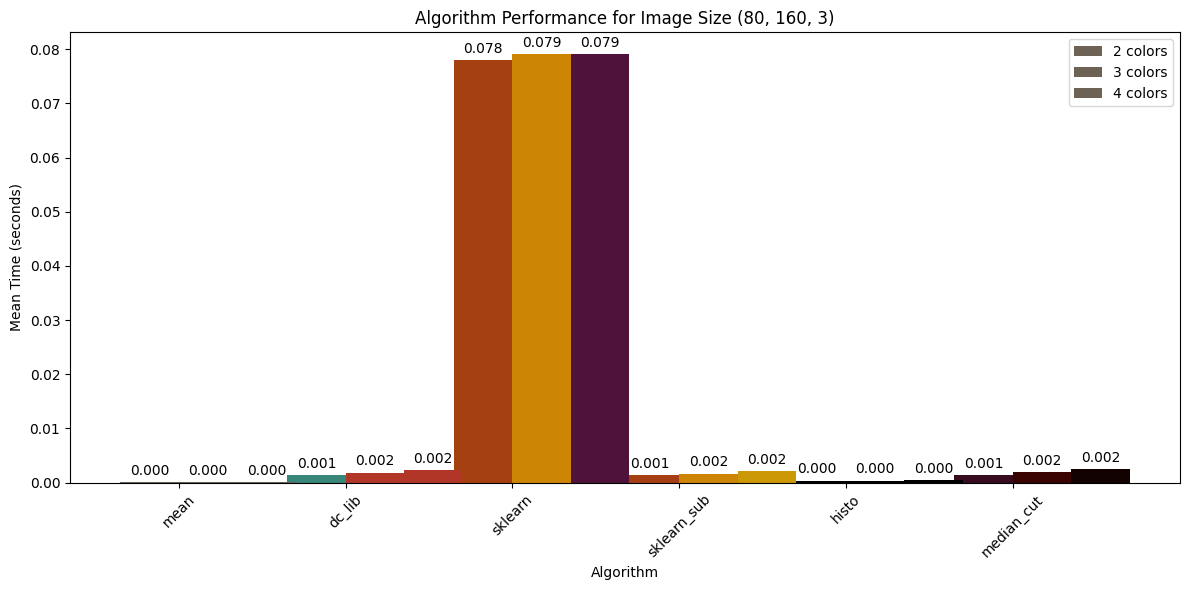

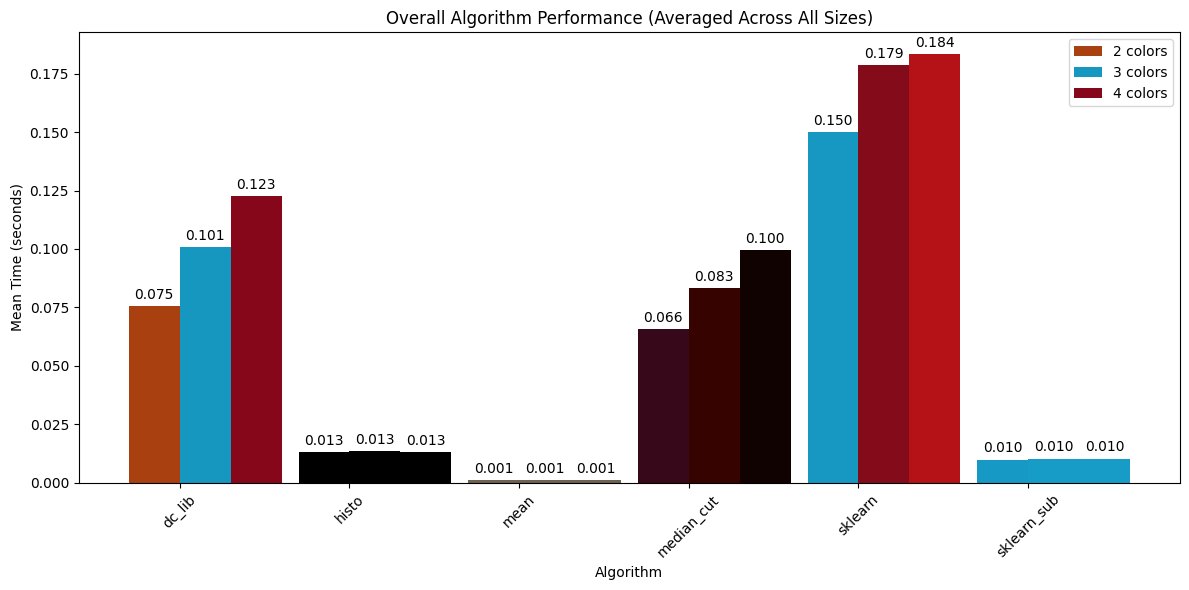

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a color map helper function
def get_bar_colors(df_subset):
    # Convert color tuples to matplotlib RGB format (0-1 range)
    colors = []
    for color_tuple in df_subset['Color'].apply(lambda x: eval(x.split('rgb(')[1].split(')')[0])):
        colors.append(np.array(color_tuple) / 255)
    return colors

# Create separate plots for each image size
for size in results_df['Size'].unique():
    # Filter data for this size
    size_data = results_df[results_df['Size'] == size]
    
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Create grouped bar plot
    bar_positions = np.arange(len(size_data['Algorithm'].unique()))
    width = 0.35
    
    # Split by number of colors
    for i, num_color in enumerate(size_data['#Color'].unique()):
        mask = size_data['#Color'] == num_color
        data = size_data[mask]
        
        bars = plt.bar(bar_positions + (i * width), 
                      data['Mean Time'],
                      width,
                      label=f'{num_color} colors',
                      color=get_bar_colors(data))
        
        # Add value labels
        plt.bar_label(bars, fmt='%.3f', padding=3)
    
    # Customize plot
    plt.title(f'Algorithm Performance for Image Size {size}')
    plt.xlabel('Algorithm')
    plt.ylabel('Mean Time (seconds)')
    plt.xticks(bar_positions + width/2, size_data['Algorithm'].unique(), rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create summary plot
plt.figure(figsize=(12, 6))
summary_data = results_df.groupby(['Algorithm', '#Color'])['Mean Time'].mean().reset_index()

bar_positions = np.arange(len(summary_data['Algorithm'].unique()))
width = 0.30

for i, num_color in enumerate(summary_data['#Color'].unique()):
    mask = summary_data['#Color'] == num_color
    data = summary_data[mask]
    
    # For the summary, use average colors from the original dataset
    color_data = results_df[results_df['#Color'] == num_color].groupby('Algorithm')['Color'].first().reset_index()
    
    bars = plt.bar(bar_positions + (i * width), 
                  data['Mean Time'],
                  width,
                  label=f'{num_color} colors',
                  color=get_bar_colors(color_data))
    
    plt.bar_label(bars, fmt='%.3f', padding=3)

plt.title('Overall Algorithm Performance (Averaged Across All Sizes)')
plt.xlabel('Algorithm')
plt.ylabel('Mean Time (seconds)')
plt.xticks(bar_positions + width/2, summary_data['Algorithm'].unique(), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()
